In [18]:
import timeit
import time
from pathlib import Path
import random
import sys
import re
sys.path.append(str(Path.cwd().parent / "classes"))
sys.path.append(str(Path.cwd().parent))



import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sim_config import SimConfiguration
from simulation import Simulation


numbers = re.compile(r"\d+\.\d+")


TREES_PATH = Path.cwd() / "other_mammals_data"

In [19]:
def refresh_sim(tree_file):
    seed = time.time_ns()%1000000
    random.seed(seed)
    tree_path = Path(tree_file)

    fasta_path = (tree_path.parent / (tree_path.stem + ".fasta")).resolve()
    fasta_text = fasta_path.read_text().replace("-","")
    fasta_seqs = fasta_text.split(">")[1:]
    sequences_length = [len(seq.replace("\n","")) for seq in fasta_seqs]

    min_seq_len = int(min(sequences_length) *0.8)
    max_seq_len = int(max(sequences_length) *1.1)

    ROOT_SEQUENCE_LENGTH = random.randint(min_seq_len, max_seq_len)

    indel_rate = random.uniform(0.0001, 0.05)
    length_param_alpha = random.uniform(1.01, 2.0)
    print("seed=", seed, "indel_rate=",indel_rate, "Root length=", ROOT_SEQUENCE_LENGTH)

    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=length_param_alpha,
                                indel_truncated_length=50,
                                rate_ins=indel_rate, rate_del=indel_rate,
                                deletion_extra_edge_length=50,
                                switch_factor=200,
                                seed=seed)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)
    return sim

In [20]:
time_log = {"blocklist": [],
            "naive": [],
            "dataset": [],
            "total_branches": [],
            "average_root": []
            }

for tree in TREES_PATH.iterdir():
    if tree.suffix == ".fasta":
        continue
    print(tree.stem)
    times_of_list, times_of_naive = [], []
    root_lengths = []
    for _ in range(5):
        current_sim = refresh_sim(str(tree))
        root_lengths.append(current_sim.sim_nodes[1].length_of_sequence_before)

        blocklist_time = timeit.timeit(current_sim.msa_from_blocklist, number=1)
        times_of_list.append(blocklist_time)
        print("Blocklist time","is", blocklist_time, "sec")
        
        naive_time = timeit.timeit(current_sim.msa_from_naive, number=1)
        print("Naive_time","is", naive_time, "sec")
        times_of_naive.append(naive_time)
    time_log["blocklist"].append(np.mean(times_of_list))
    time_log["naive"].append(np.mean(times_of_naive))
    time_log["dataset"].append(tree.stem)

    tree_text = tree.read_text()
    sum_of_branches = sum(map(float, numbers.findall(tree_text)))
    time_log["total_branches"].append(sum_of_branches)
    time_log["average_root"].append(np.mean(root_lengths))


54102_NT_AL_AA
seed= 777202 indel_rate= 0.034322207659483045 Root length= 443
Blocklist time is 0.0647312890014291 sec
Naive_time is 0.2356153410000843 sec
seed= 701348 indel_rate= 0.03631935150237922 Root length= 296
Blocklist time is 0.036662817999967956 sec
Naive_time is 0.08939848999943933 sec
seed= 732472 indel_rate= 0.042269519674169816 Root length= 425
Blocklist time is 0.06585196100058965 sec
Naive_time is 0.28818882899940945 sec
seed= 189432 indel_rate= 0.04646248728033527 Root length= 231
Blocklist time is 0.03080551600032777 sec
Naive_time is 0.06636155399974086 sec
seed= 279233 indel_rate= 0.01920048362811493 Root length= 361
Blocklist time is 0.048335982999560656 sec
Naive_time is 0.150661849998869 sec
100131017_NT_AL_AA
seed= 785751 indel_rate= 0.012025296645896924 Root length= 525
Blocklist time is 0.06962317999932566 sec
Naive_time is 0.24144340400016517 sec
seed= 456674 indel_rate= 0.006007688974004036 Root length= 671
Blocklist time is 0.08575991399993654 sec
Naive_ti

In [21]:
time_log_df = pd.DataFrame(time_log)

In [22]:
time_log_df["time_ratio"] = (time_log_df["naive"]/ time_log_df["blocklist"] )

In [23]:
time_log_df.to_csv("approximate_bats_runtime.csv", index=False)

<Axes: xlabel='average_root', ylabel='time_ratio'>

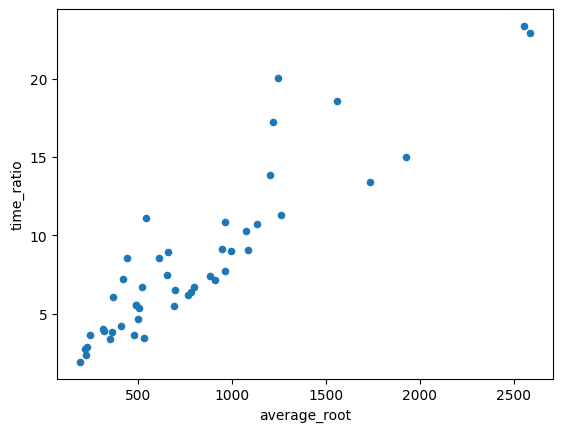

In [24]:
time_log_df.plot(x="average_root", y="time_ratio", kind="scatter")


In [25]:
time_log_df.describe()

,blocklist,naive,total_branches,average_root,time_ratio
count,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.107010,1.231713,9.863625,810.412766,8.379015
std,0.070695,1.619609,3.308163,552.794751,5.267729
min,0.024317,0.046462,3.817947,190.600000,1.910715
25%,0.055913,0.225168,7.536847,433.400000,4.430155
50%,0.080677,0.647266,9.917629,659.000000,7.134829
75%,0.137808,1.373599,12.399466,1034.500000,10.494917
max,0.302468,7.024932,20.206212,2588.800000,23.384437


In [26]:
sorted_time_log_df = time_log_df.sort_values(by="dataset")

In [29]:
simulation_times_df = pd.read_csv("empirical_times_others.csv")

In [30]:
simulation_times_df = simulation_times_df.sort_values(by="File_Name")

In [31]:
#Real compute time with blocklist method
simulation_times_df["Duration_Hours"].sum()

np.float64(699.7500000000001)

In [32]:
#Inferred compute time with naive method
(simulation_times_df["Duration_Hours"]*sorted_time_log_df["time_ratio"]).sum()

np.float64(5929.429833656566)

In [16]:
#Real compute time with blocklist method
simulation_times_df["Duration_Hours"].sum()

np.float64(56.38)

In [17]:
#Inferred compute time with naive method
(simulation_times_df["Duration_Hours"]*sorted_time_log_df["time_ratio"]).sum()

np.float64(269.3576946487911)